In [1]:
import numpy as np
import scipy.io as io
import scipy.linalg as la
import pylab as plt

In [2]:
np.printoptions(precision=2);

In [3]:
import scipy
scipy.__version__

'1.7.1'

In [35]:
f = io.loadmat('/Users/mmadduri/Documents/PhD/ResearchMaterials/Code/BMI_Model/matlab/ndata.mat')['n_data']
f_norm = io.loadmat('/Users/mmadduri/Documents/PhD/ResearchMaterials/Code/BMI_Model/matlab/ndata_norm.mat')['n_data']
d = io.loadmat('/Users/mmadduri/Documents/PhD/ResearchMaterials/Code/BMI_Model/matlab/decoder.mat')
A = d['dec_A']
C = d['dec_H']
Q = d['dec_W'] # process noise covariance
R = d['dec_Q'] # measurement noise covariance

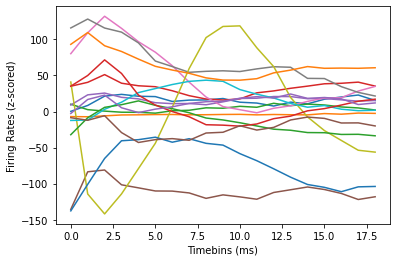

In [38]:
for iN in range(16):
    nact = np.squeeze(f_norm[:-1, iN, :])
    plt.plot(np.mean(nact, 1))
plt.xlabel('Timebins (ms)')
plt.ylabel("Firing Rates (z-scored)")
plt.show()

Assuming process model 
$$ x^+ = A x + v,\ f = C x + w,\ v\sim\mathcal{N}(0,Q),\ w\sim\mathcal{N}(0,R), $$
the Kalman filter is
$$ \widehat{x}^+ = A \widehat{x} + L (f - \widehat{f}) = (A - L C) \widehat{x} + L f,\ \widehat{f} = C \widehat{x}, $$
where $L$ is obtained by solving the discrete algebraic Riccati equation (DARE)
$$ A P A^\top - P - (A P C^\top ) (R + C P C^\top)^{-1} (C P A^\top) + Q = 0  $$
for $P = P > 0$ and setting
$$ L = P C^\top (C P C^\top + R)^{-1}. $$

(If the `control` package is available, $L$ can be obtained via `L = control.lqr(A.T,C.T,Q,R).T`.)

In [39]:
P = la.solve_discrete_are(A.T,C.T,Q,R)
assert np.allclose( 0, A @ P @ A.T - P - (A @ P @ C.T) @ la.inv(R + C @ P @ C.T) @ (C @ P @ A.T) + Q )

L = P @ C.T @ la.inv(C @ P @ C.T + R)

LC = L @ C
A_LC = A - LC

#assert np.allclose( L, control.lqr(A.T,C.T,Q,R).T )

LinAlgError: The associated symplectic pencil has eigenvaluestoo close to the unit circle

In [7]:
def kf(x0,f):
    x_ = [x0]
    for b in np.arange(B):
        x_.append(x_[-1] @ A_LC.T  + f[b] @ L.T)
    return np.asarray(x_)

In [254]:
if 1: # real data
    B,N,T = f.shape # bins, neurons, trials
    f = f + np.random.randn(B,N,T)
    D = A.shape[0] # state dimension
    x0 = np.random.randn(D,T) # random initial conditions
    x0[4,:] = 1
else: # synthetic (debug) data
    B,N,T,D = 2,1,7,1
    A_LC = np.array([[2]]); L = np.array([[3]])
    f = np.random.randn(B,N,T)

Create data arrays for states $X$ and firing rates $F$

In [255]:
#x0 = np.eye(D)[-1]
F = []; X = []
for t in np.arange(T):
    x0_ = x0[...,t].flatten()
    f_ = f[...,t].flatten()
    F.append(np.hstack((x0_,f_)))
    X.append(kf(x0_,f[...,t]).flatten())
F = np.asarray(F).T
X = np.asarray(X).T

Determine $K$ *a priori* (from Kalman filter matrices) such that $X = K F$ 

In [256]:
I = np.eye(D) # identity
Z = np.zeros((D,D)) # zeros
ZDN = np.zeros((D,N)) # zeros

K = [ np.hstack([I] + [ZDN]*B) ]
K += [ np.hstack([A_LC] + [L] + [ZDN]*(B-1)) ]

for b in np.arange(B-1):
    K.append( np.hstack([A_LC @ K[-1][:,:D+(b+1)*N]] + [L] + [ZDN]*(B-b-2) ) )

K = np.vstack(K)

Determine $K$ using linear least-squares in $X = K F$

In [266]:
K_pinv = X @ la.pinv(F) # works even if F @ F.T isn't invertible
K_direct = X @ F.T @ la.inv(F @ F.T) # faster but needs F @ F.T invertible
assert np.allclose(K_direct, K_pinv) # same answer when F @ F.T invertible

The $K$'s are identical and both perfectly reproduce the data

In [267]:
assert np.allclose(K, K_pinv)
assert np.allclose(X, K @ F)